### Accessing Synaptic Response Data

Most of the data we want to access from the SynPhys database is aggregated _per-synapse_. This means that each row in a database table corresponds to a single synapse, and the columns contain information about that synapse.

Sometimes, however, we want to access data about individual evoked synaptic events. We have a few options in this case:

- Use a "medium" sized database to access summary information about each event (the results of curve fitting to regions of the data where we expect to see an evoked synaptic response).
- Use a "full" sized database to access the raw time-series data where we expect to see evoked synaptic responses
- Download the original NWB files to access the complete time-series data (we won't explore this option here, but see `accessing_raw_data.ipynb`)

In [1]:
from aisynphys.database import SynphysDatabase
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Download a medium-sized DB to look at individual synaptic event properties
db = SynphysDatabase.load_current('medium')

  /home/luke/ai_synphys_cache/database/synphys_r2.1_medium.sqlite
  [####################]  100.00% (11.13 GB / 11.1 GB)  0.000 B/s   remaining
  done.


In [3]:
# load information about all synapses
pair_query = db.pair_query(
    experiment_type='standard multipatch',
    synapse=True,
)
all_pairs = pair_query.all()

# Pick a random synapse with relatively large amplitude
large_synapses = [
    pair for pair in all_pairs if 
    pair.synapse is not None and
    pair.synapse.psp_amplitude is not None and 
    pair.synapse.psp_amplitude > 2e-3
]

synapse = large_synapses[0]

We have selected a synapse from the database. If this was a "small" sized database, we could only look up summary statistics about this synapse--for example, the average amplitude of PSPs under various conditions. 

Because this database is "medium" sized, it also contains information collected from individual PSPs. Below, we plot a histogram of all PSP amplitudes measured from this synapse. (Note that this includes all PSPs avoked across many different types of stimulus, so we expect to see a range of strengths depending on the variance and STP states that the synapse experienced) 

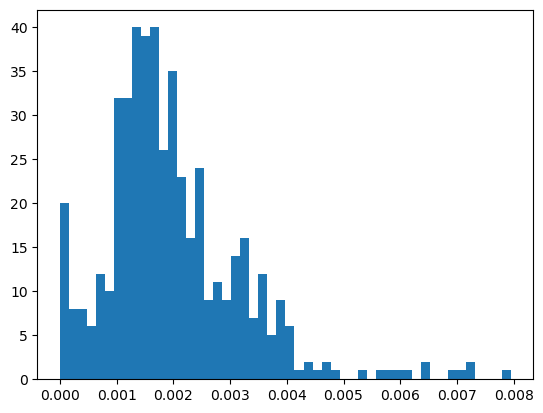

In [4]:
fits = [
    pr.pulse_response_fit for pr in synapse.pulse_responses
    if pr.pulse_response_fit is not None
]

amps = [fit.fit_amp for fit in fits]
plt.hist(amps, bins=50);

What if we wanted to see the actual time-series data from which these amplitudes were measured? This level of data is only available in the "full" sized database (which is about 270 GB). We'll start downloading that dababase below and leave it overnight to finish. If anything goes wrong, we can simply try again and it will automatically resume downloading where it left off. 

In [5]:
full_db = SynphysDatabase.load_current('full')

  /home/luke/ai_synphys_cache/database/synphys_r2.1_full.sqlite
  [####################]  100.00% (267.68 GB / 267.7 GB)  0.000 B/s   remaining
  done.


In [6]:
# Now that the larger database is loaded, we need to reload the synapse object
full_synapse = full_db.pair_from_ext_id(synapse.ext_id)

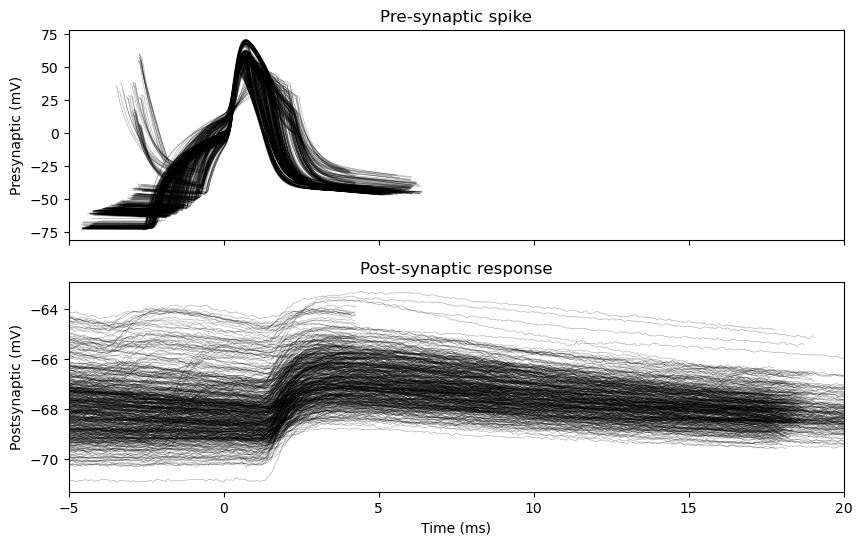

In [7]:
# Plot time series from all current clamp pulse responses, time-aligned
# to the onset of the first presynaptic spike

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].set_title('Pre-synaptic spike')
ax[1].set_title('Post-synaptic response')
ax[0].set_ylabel('Presynaptic (mV)')
ax[1].set_ylabel('Postsynaptic (mV)')
ax[1].set_xlabel('Time (ms)')
ax[0].set_xlim(-5, 20)

for pr in full_synapse.pulse_responses:
    if pr.recording.patch_clamp_recording.clamp_mode != 'ic':
        continue
    pre = pr.pre_tseries
    post = pr.post_tseries

    # Align traces to spike onset
    if len(pr.stim_pulse.spikes) == 0:
        continue  # skip if no presynaptic spikes were detected
    spike_time = pr.stim_pulse.spikes[0].onset_time
    if spike_time is None:
        continue  # skip if we couldn't determine the onset time of the first spike
    pre = pre.copy(t0=pre.t0-spike_time)
    post = post.copy(t0=post.t0-spike_time)
    ax[0].plot(pre.time_values*1000, pre.data*1000, linewidth=0.5, color='k', alpha=0.3)
    ax[1].plot(post.time_values*1000, post.data*1000, linewidth=0.5, color='k', alpha=0.3)


Each pulse-response item in the "full" database contains a snippet of data around the stimulus. The length of these snippets varies--when possible we try to record the full duration of the PSP decay, but often the PSP is interrupted by a subsequent stimulus, and thus the time series is truncated to avoid including the next PSP.

If we wanted to see more of the time series data, the only option is to read these from the original NWB files. See `accessing_raw_data.ipynb` for an example of this approach.